In [24]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import datetime
import random
import math

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import Quandl
import numpy as np
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn import tree
from sklearn.grid_search import GridSearchCV

import utils as ut
from utils import RET_PER, FIG_WIDTH, FIG_HEIGHT

sns.set_context("paper")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
tar = ut.load_target()

## increasing values

In [6]:
series = 'IV'
px_h, px_ca, px_us = ut.load_series(series)

int: 6.18220627203e-16	coef: 0.543239747314


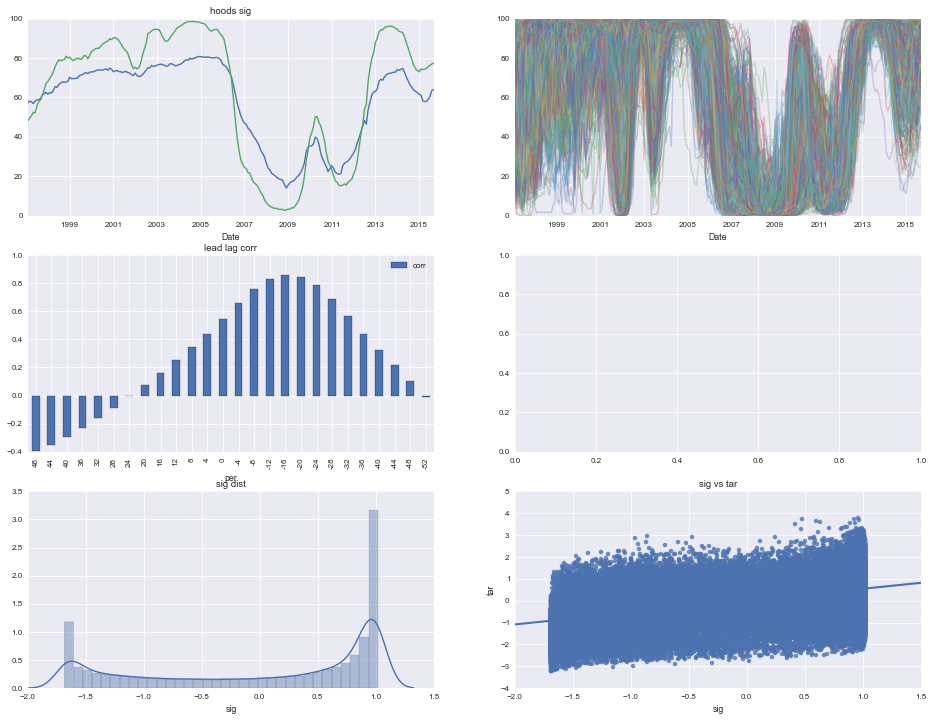

In [29]:
ut.explore_series(px_h, px_ca, px_us, tar)

## decreasing values

In [31]:
series = 'DV'
px_h, px_ca, px_us = ut.load_series(series)

int: -9.72514953918e-15	coef: -0.539402120121


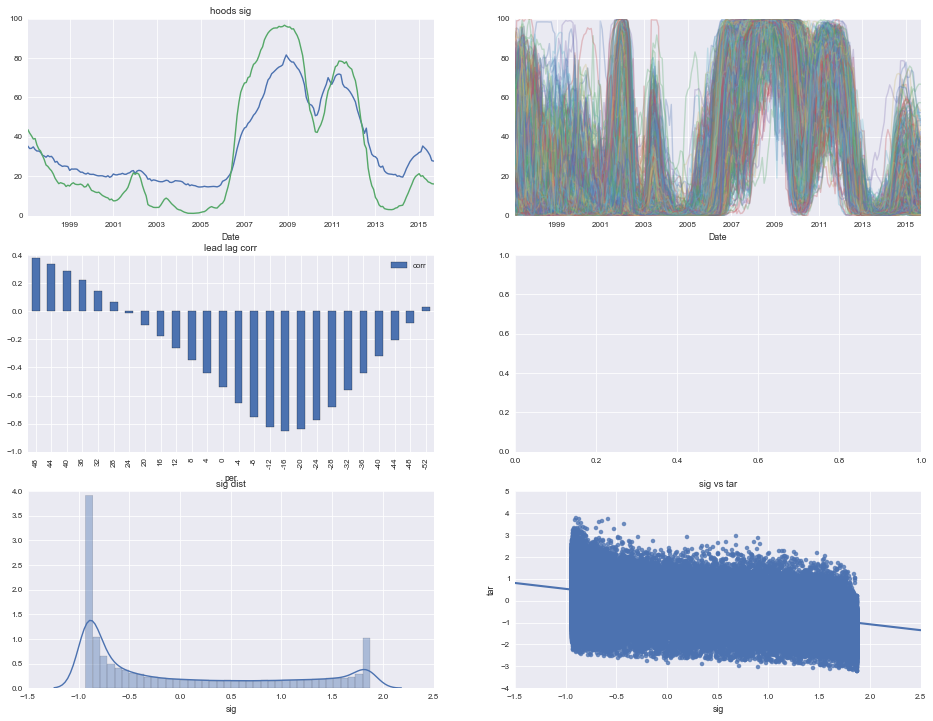

In [32]:
ut.explore_series(px_h, px_ca, px_us, tar)

## ratio sales price to list price

In [33]:
series = 'SLPR'
px_h, px_ca, px_us = ut.load_series(series)

In [34]:
px_h

,00003,00004,00007,00014,00021,00025,00032,00034,00035,00037,...,01028,01145,01213,01535,01987,02046,02637,04463,04531,05903
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-28,0.9954,0.99,0.9937,0.9801,0.9857,0.9987,0.9783,0.9757,0.9872,1.0667,...,0.9734,0.9812,1,0.9747,0.9699,0.9608,0.993141,1.0821,0.9697,0.9956


## turnover in housing market in past year

In [35]:
series = 'SPY'
px_h, px_ca, px_us = ut.load_series(series)

int: -4.63035810897e-15	coef: 0.12150467813


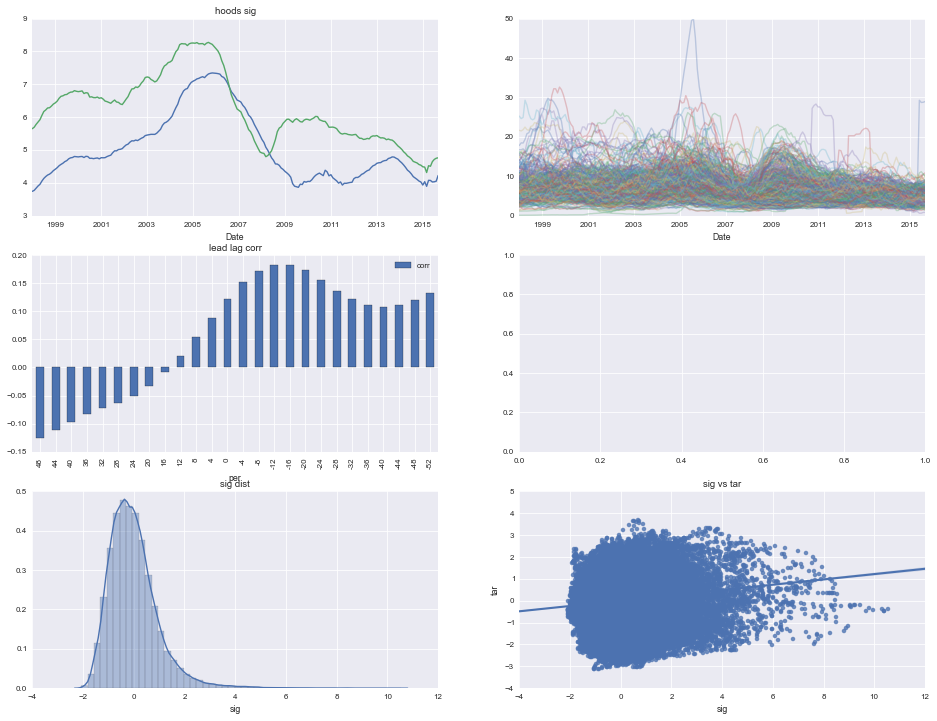

In [36]:
ut.explore_series(px_h, px_ca, px_us, tar)

## sold for gain

In [37]:
series = 'SFG'
px_h, px_ca, px_us = ut.load_series(series)

In [38]:
per = 12
px_us = px_us / px_us.shift(per) - 1.
px_ca = px_ca / px_ca.shift(per) - 1.
px_h = px_h / px_h.shift(per) - 1.

px_us = px_us.map(lambda x: 3 if x > 3 else x)
px_ca = px_ca.map(lambda x: 3 if x > 3 else x)
px_h = px_h.applymap(lambda x: 3 if x > 3 else x)

SFG_c = px_h

int: 4.45931763155e-15	coef: 0.158829595428


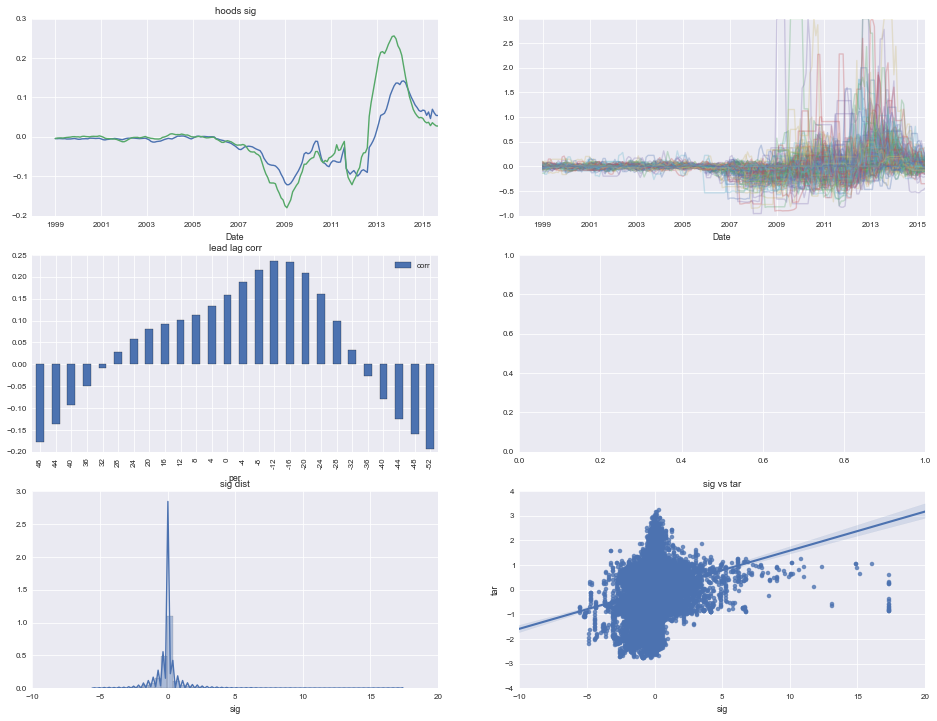

In [39]:
ut.explore_series(px_h, px_ca, px_us, tar)

## build model

In [40]:
features = {}
for i in ('IV', 'DV', 'SPY'):
    features[i] = ut.load_quandl_data('hoods', i)
features['tar'] = tar
features['SFG'] = SFG_c
df = ut.stack_and_align(features.values(), cols=features.keys()).dropna()
df = ut.ts_score(df)

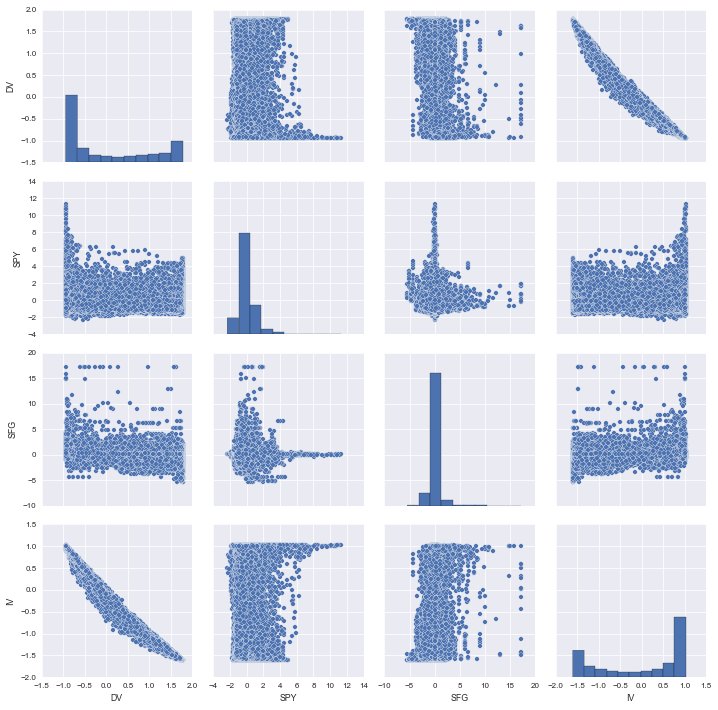

In [41]:
sns.pairplot(df[[c for c in df.columns if c != 'tar']])

r2: 0.314691539164	int: 5.48390071518e-15	coef: [-0.15347403 -0.05521668  0.0242522   0.4020261 ]	alpha: 1000


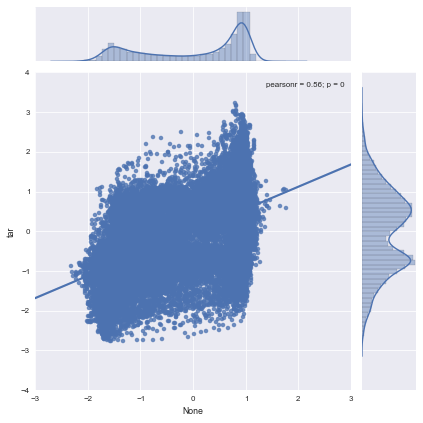

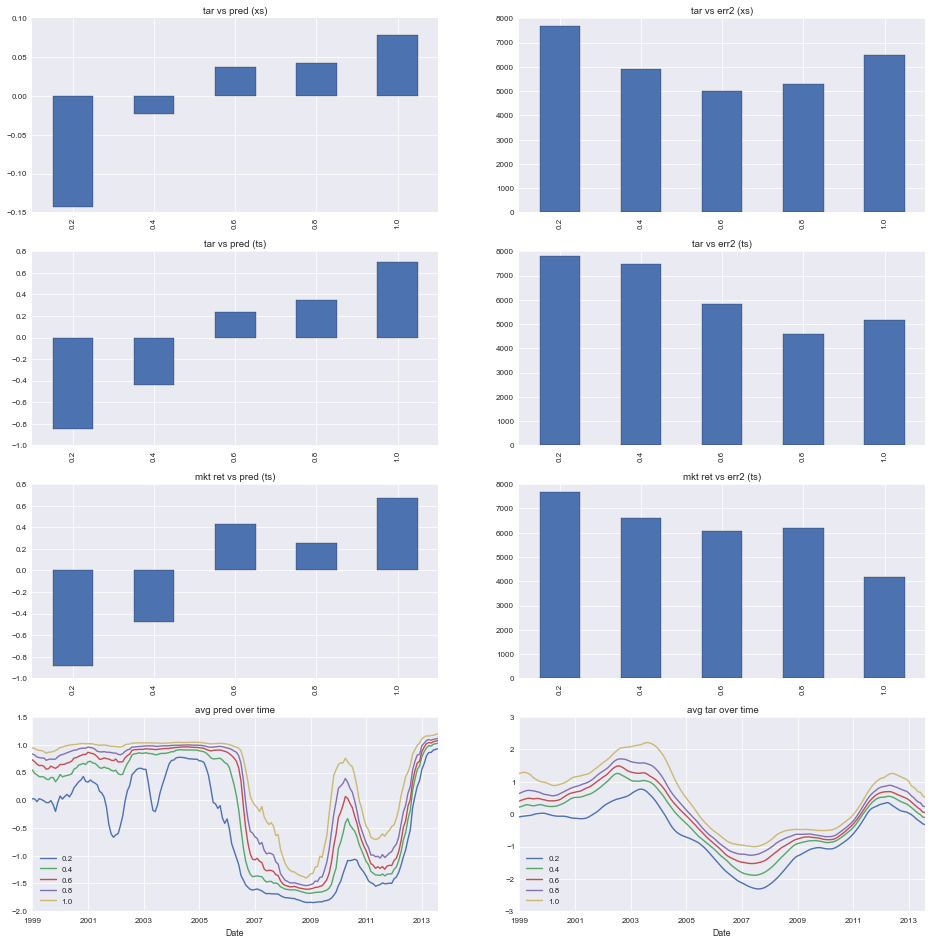

In [59]:
clf = lm.RidgeCV(alphas=[1., 10., 100, 1000, 10000, 50000, 10000000], cv=5)
clf, df_res, score = ut.build_model(clf, df)
print('r2: {2}\tint: {0}\tcoef: {1}\talpha: {3}'.format(clf.intercept_, clf.coef_, score, clf.alpha_))

r2: 0.316371468784	int: 4.83388173451e-15	coef: [-0.         -0.04873585  0.01589749  0.55641148]	alpha: 0.01


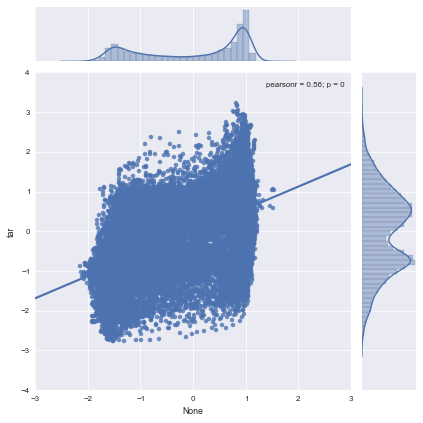

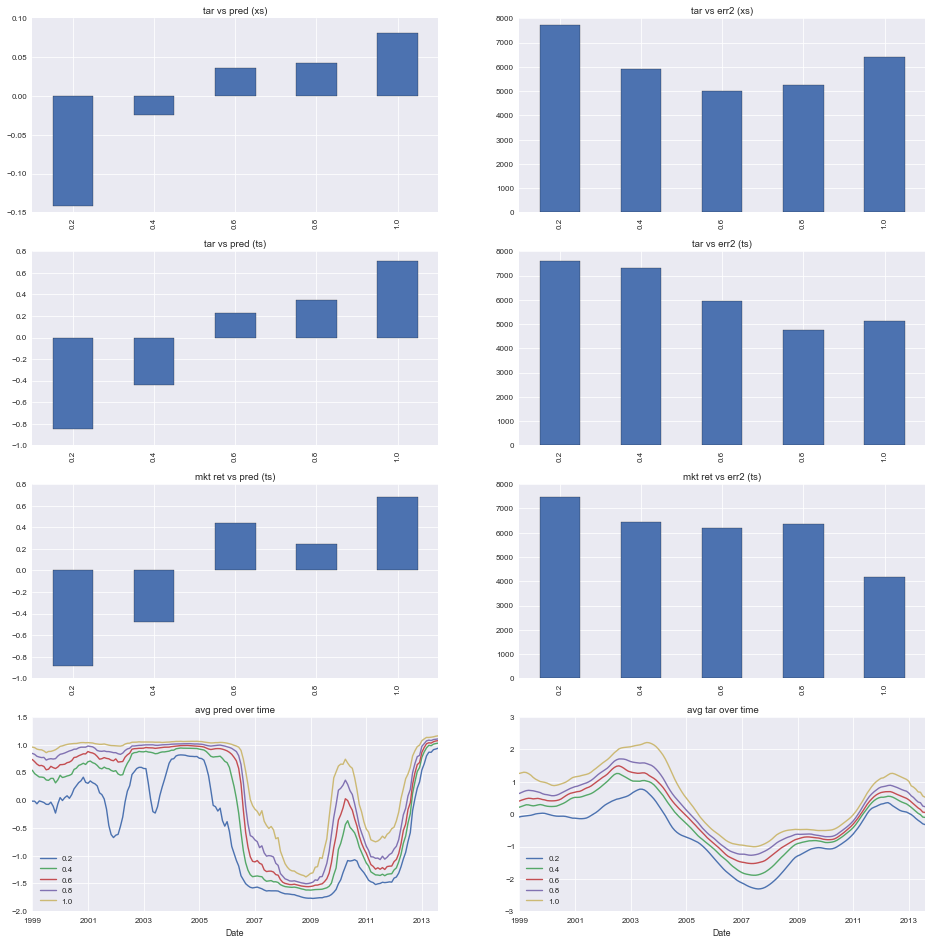

In [58]:
clf = lm.LassoCV(alphas=[.0001, .001, .01, .1], cv=5)
clf, df_res, score = ut.build_model(clf, df)
score = clf.score(df[[c for c in df.columns if c != 'tar']], df['tar'])
print('r2: {2}\tint: {0}\tcoef: {1}\talpha: {3}'.format(clf.intercept_, clf.coef_, score, clf.alpha_))

r2: 0.337639344006


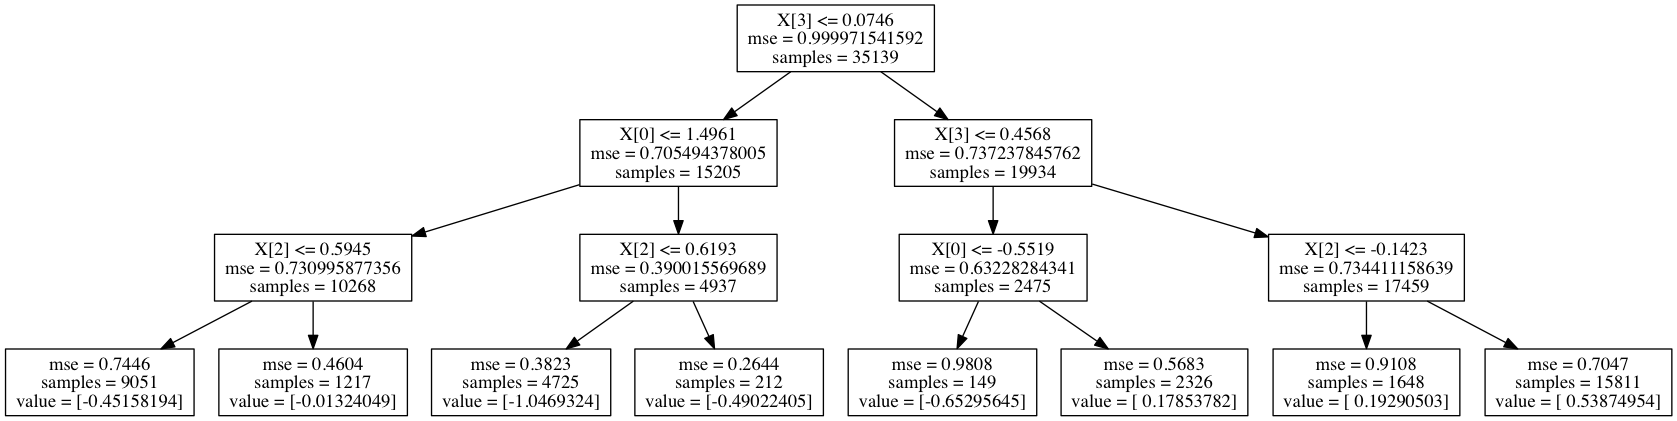

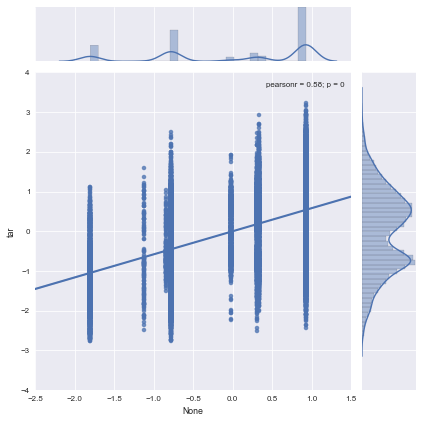

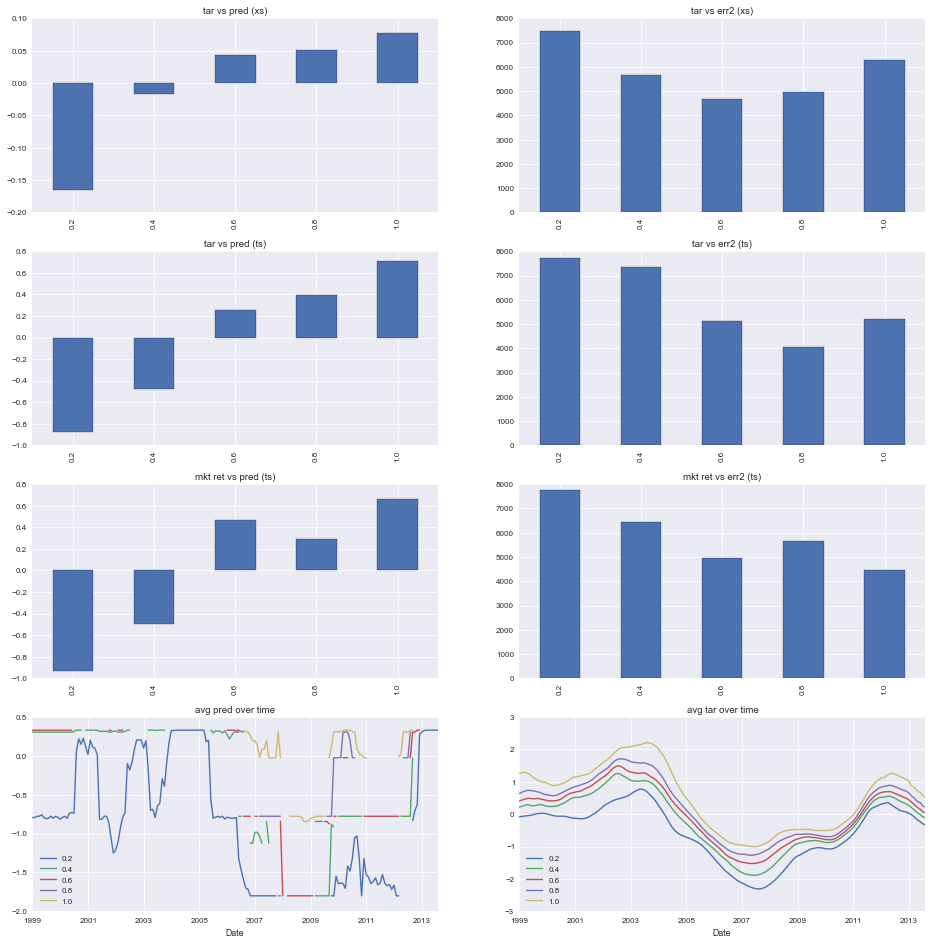

In [57]:
clf = GridSearchCV(tree.DecisionTreeRegressor(), param_grid={'max_depth': [3,5,7], 'max_features': [None, 1, 2]}, cv=5)
clf, df_res, score = ut.build_model(clf, df)
print('r2: {0}'.format(score,))
ut.tree_vis(clf.best_estimator_)

r2: 0.328966803343


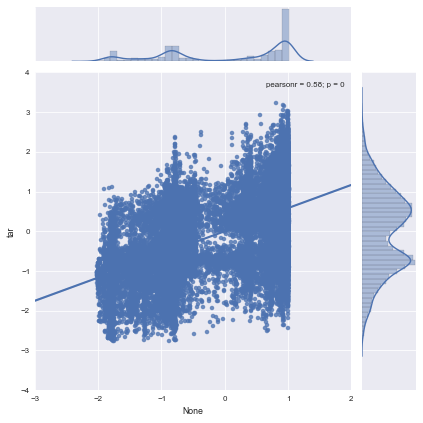

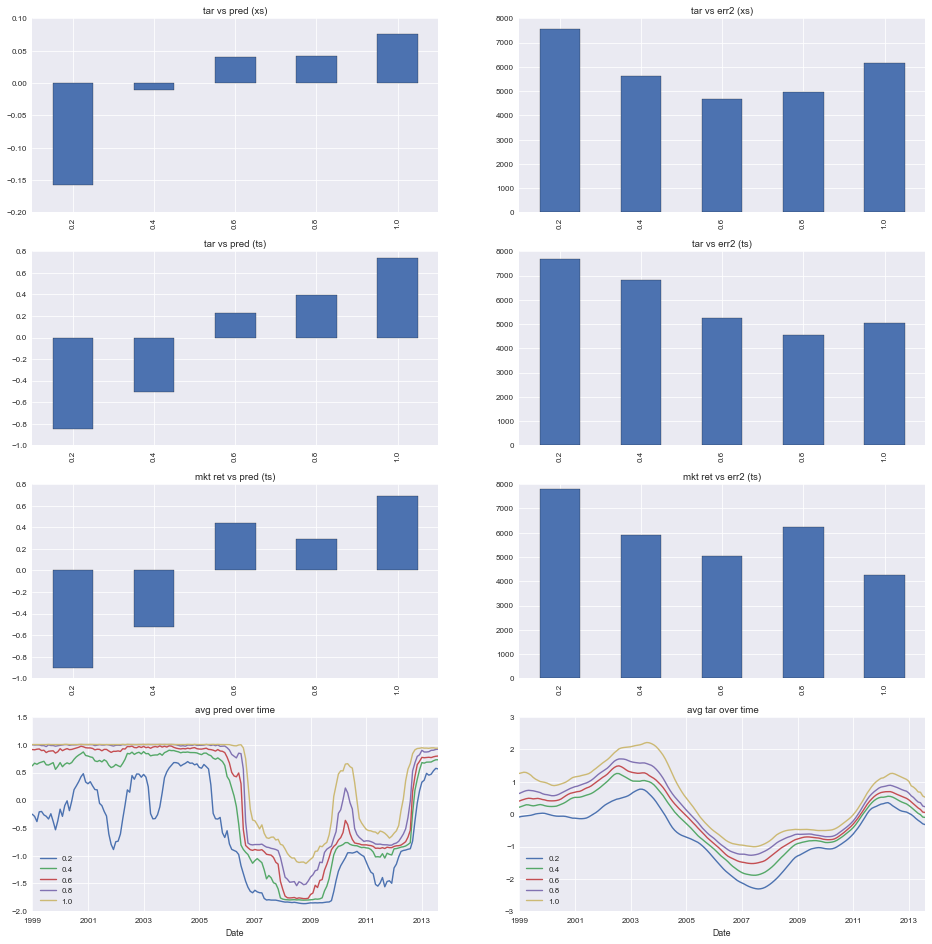

In [60]:
clf = GridSearchCV(rf(n_estimators=100), param_grid={'max_depth': [3,5,7], 'max_features': [None, 1, 2]}, cv=5)
clf, df_res, score = ut.build_model(clf, df)
print('r2: {0}'.format(score,))